# Swarm check in data

### Import Python tools and Jupyter configuration

In [1]:
%load_ext lab_black

In [55]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import altair as alt
import requests
import json
import sqlite3
from datetime import datetime

In [56]:
import altair as alt
import altair_latimes as lat
from datetime import datetime

alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")

ThemeRegistry.enable('latimes')

In [57]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

### Get the data using this tool from [Swarm-to-SQLite](https://github.com/dogsheep/swarm-to-sqlite)

In [63]:
today = datetime.today().strftime("%Y-%m-%d")

In [64]:
# !swarm-to-sqlite data/raw/checkins.db --token=UXTT2DWG0ZF01W4X4FZXAL2LYLQ5CLBKW5ZTEB3QJTKZAONN

### Read the sqlite database we downloaded

In [65]:
import sqlite3

# Create a SQL connection to our SQLite database
cnx = sqlite3.connect("data/raw/checkins.db")

### Create dataframes for various tables in the DB

In [66]:
venues = pd.read_sql_query("SELECT * FROM venues", cnx)
checkins = pd.read_sql_query("SELECT * FROM checkins", cnx)
categories = pd.read_sql_query("SELECT * FROM categories", cnx)
categories_venues = pd.read_sql_query("SELECT * FROM categories_venues", cnx)

### Merge categories and venues

In [67]:
category_lookup = pd.merge(
    categories_venues, categories, left_on="categories_id", right_on="id"
)

In [68]:
venue_lookup = pd.merge(categories_venues, venues, left_on="venues_id", right_on="id")

### Merge checkins and venues

In [80]:
src = pd.merge(checkins, venue_lookup, left_on="venue", right_on="id")

In [81]:
df = pd.merge(src, category_lookup, on="venues_id")

In [82]:
df_slim = df[
    [
        "id_x",
        "timeZoneOffset",
        "isMayor",
        "created",
        "name_x",
        "venue",
        "address",
        "crossStreet",
        "postalCode",
        "cc",
        "city",
        "state",
        "country",
        "latitude",
        "longitude",
        "pluralName",
    ]
].copy()

In [83]:
df_slim.sort_values("created", ascending=False).head(10)

,id_x,timeZoneOffset,isMayor,created,name_x,venue,address,crossStreet,postalCode,cc,city,state,country,latitude,longitude,pluralName
0,61005d18fd90637440599639,-420,1,2021-07-27T19:23:04,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,US,El Segundo,CA,United States,33.930487,-118.382373,Offices
101,61003ed5deefb67430ef15f3,-420,1,2021-07-27T17:13:57,Los Angeles Superior Airport Courthouse,4b1936c1f964a5204fd923e3,11701 S LA Cienega Blvd,None,90045,US,Los Angeles,CA,United States,33.928316,-118.371332,Courthouses
107,61002ca79c8f824aa79cd8be,-420,0,2021-07-27T15:56:23,Annenberg PetSpace,594c1e59fd16bb35d2d1a491,12005 Bluff Creek Dr,Artisan Way,90094,US,Los Angeles,CA,United States,33.981856,-118.403321,Community Centers
102,60ff206ce6337919ebdf142f,-420,1,2021-07-26T20:51:56,Los Angeles Superior Airport Courthouse,4b1936c1f964a5204fd923e3,11701 S LA Cienega Blvd,None,90045,US,Los Angeles,CA,United States,33.928316,-118.371332,Courthouses
1,60ff18b26d0a0922e2394955,-420,1,2021-07-26T20:18:58,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,US,El Segundo,CA,United States,33.930487,-118.382373,Offices
103,60fef03cc8448a64124af7c7,-420,1,2021-07-26T17:26:20,Los Angeles Superior Airport Courthouse,4b1936c1f964a5204fd923e3,11701 S LA Cienega Blvd,None,90045,US,Los Angeles,CA,United States,33.928316,-118.371332,Courthouses
108,60fd9b6c46109e0512b59bd2,-420,0,2021-07-25T17:12:12,Target,4a9087eff964a520601820e3,10820 Jefferson Blvd,at Cota St,90230,US,Culver City,CA,United States,33.998959,-118.393326,Big Box Stores
116,60fd8e58a27bdf6ff95828ca,-420,0,2021-07-25T16:16:24,7-Eleven,4b804c94f964a520a46530e3,11299 Washington Blvd,at Sawtelle Blvd,90230,US,Culver City,CA,United States,34.004798,-118.414742,Convenience Stores
118,60fcb9b6a5cd2c5ecbdc115b,-420,0,2021-07-25T01:09:10,Veteran's Memorial Park,4b65c18bf964a520b2fd2ae3,4117 Overland Ave,Culver Blvd.,90230,US,Culver City,CA,United States,34.011895,-118.402895,Parks
121,60fc75ebba727943cd83ab15,-420,0,2021-07-24T20:19:55,Chick-fil-A,5845de9f45005e3e7f774994,4050 Lincoln Blvd,None,90292,US,Venice,CA,United States,33.989410,-118.446411,Fast Food Restaurants


### Dates

In [84]:
df_slim["date"] = pd.to_datetime(df_slim["created"], format="%Y-%m-%d")

In [85]:
df_slim["date"] = pd.to_datetime(df_slim["date"].dt.strftime("%Y-%m-%d"))

In [86]:
df_slim["year"] = df_slim["date"].dt.year.astype(str)
df_slim["quarter"] = df_slim["date"].dt.quarter.astype(str)
df_slim["day"] = df_slim["date"].dt.day.astype(str)
df_slim["month"] = df_slim["date"].dt.month.astype(str)
df_slim["weekday"] = df_slim["date"].dt.day_name()
df_slim["monthname"] = df_slim["date"].dt.month_name()
df_slim["monthday"] = df_slim["date"].dt.strftime("%m-%d")
df_slim["monthyear"] = df_slim["date"].dt.strftime("%m-%Y")

In [87]:
df_slim.head()

,id_x,timeZoneOffset,isMayor,created,name_x,venue,address,crossStreet,postalCode,cc,city,state,country,latitude,longitude,pluralName,date,year,quarter,day,month,weekday,monthname,monthday,monthyear
0,61005d18fd90637440599639,-420,1,2021-07-27T19:23:04,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,US,El Segundo,CA,United States,33.930487,-118.382373,Offices,2021-07-27,2021,3,27,7,Tuesday,July,07-27,07-2021
1,60ff18b26d0a0922e2394955,-420,1,2021-07-26T20:18:58,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,US,El Segundo,CA,United States,33.930487,-118.382373,Offices,2021-07-26,2021,3,26,7,Monday,July,07-26,07-2021
2,60f5ac06adfa9e785e63c4c9,-420,1,2021-07-19T16:44:54,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,US,El Segundo,CA,United States,33.930487,-118.382373,Offices,2021-07-19,2021,3,19,7,Monday,July,07-19,07-2021
3,5f62493872ec1b3021cd2796,-420,1,2020-09-16T17:19:52,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,US,El Segundo,CA,United States,33.930487,-118.382373,Offices,2020-09-16,2020,3,16,9,Wednesday,September,09-16,09-2020
4,5e6699a1fe63ee00083b6cf2,-420,1,2020-03-09T19:31:45,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,US,El Segundo,CA,United States,33.930487,-118.382373,Offices,2020-03-09,2020,1,9,3,Monday,March,03-09,03-2020


In [88]:
df_slim.columns = df_slim.columns.str.lower()

In [89]:
df_slim.rename(columns={"id_x": "checkinid", "name_x": "place"}, inplace=True)

In [90]:
df_slim.dtypes

checkinid                 object
timezoneoffset             int64
ismayor                    int64
created                   object
place                     object
venue                     object
address                   object
crossstreet               object
postalcode                object
cc                        object
city                      object
state                     object
country                   object
latitude                 float64
longitude                float64
pluralname                object
date              datetime64[ns]
year                      object
quarter                   object
day                       object
month                     object
weekday                   object
monthname                 object
monthday                  object
monthyear                 object
dtype: object

---

### Change over time

In [91]:
places_time_grouped = (
    df_slim.groupby(["year"]).agg({"checkinid": "count"}).reset_index()
)

In [92]:
places_time_grouped.rename(columns={"checkinid": "count"}, inplace=True)

In [93]:
places_time_grouped.head(20)

,year,count
0,2010,286
1,2011,538
2,2012,1131
3,2013,683
4,2014,293
5,2015,239
6,2016,419
7,2017,411
8,2018,407
9,2019,624


In [94]:
alt.Chart(places_time_grouped).mark_bar().encode(x="year", y="count").properties(
    width=600, height=400
)

alt.Chart(...)

---

### Venue types

In [95]:
df_slim.sort_values("created", ascending=False).head(10)

,checkinid,timezoneoffset,ismayor,created,place,venue,address,crossstreet,postalcode,cc,city,state,country,latitude,longitude,pluralname,date,year,quarter,day,month,weekday,monthname,monthday,monthyear
0,61005d18fd90637440599639,-420,1,2021-07-27T19:23:04,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,US,El Segundo,CA,United States,33.930487,-118.382373,Offices,2021-07-27,2021,3,27,7,Tuesday,July,07-27,07-2021
101,61003ed5deefb67430ef15f3,-420,1,2021-07-27T17:13:57,Los Angeles Superior Airport Courthouse,4b1936c1f964a5204fd923e3,11701 S LA Cienega Blvd,None,90045,US,Los Angeles,CA,United States,33.928316,-118.371332,Courthouses,2021-07-27,2021,3,27,7,Tuesday,July,07-27,07-2021
107,61002ca79c8f824aa79cd8be,-420,0,2021-07-27T15:56:23,Annenberg PetSpace,594c1e59fd16bb35d2d1a491,12005 Bluff Creek Dr,Artisan Way,90094,US,Los Angeles,CA,United States,33.981856,-118.403321,Community Centers,2021-07-27,2021,3,27,7,Tuesday,July,07-27,07-2021
102,60ff206ce6337919ebdf142f,-420,1,2021-07-26T20:51:56,Los Angeles Superior Airport Courthouse,4b1936c1f964a5204fd923e3,11701 S LA Cienega Blvd,None,90045,US,Los Angeles,CA,United States,33.928316,-118.371332,Courthouses,2021-07-26,2021,3,26,7,Monday,July,07-26,07-2021
1,60ff18b26d0a0922e2394955,-420,1,2021-07-26T20:18:58,Los Angeles Times,5b4bd8aacad1b60036b3c14f,2300 E Imperial Hwy,Douglas Street,90245,US,El Segundo,CA,United States,33.930487,-118.382373,Offices,2021-07-26,2021,3,26,7,Monday,July,07-26,07-2021
103,60fef03cc8448a64124af7c7,-420,1,2021-07-26T17:26:20,Los Angeles Superior Airport Courthouse,4b1936c1f964a5204fd923e3,11701 S LA Cienega Blvd,None,90045,US,Los Angeles,CA,United States,33.928316,-118.371332,Courthouses,2021-07-26,2021,3,26,7,Monday,July,07-26,07-2021
108,60fd9b6c46109e0512b59bd2,-420,0,2021-07-25T17:12:12,Target,4a9087eff964a520601820e3,10820 Jefferson Blvd,at Cota St,90230,US,Culver City,CA,United States,33.998959,-118.393326,Big Box Stores,2021-07-25,2021,3,25,7,Sunday,July,07-25,07-2021
116,60fd8e58a27bdf6ff95828ca,-420,0,2021-07-25T16:16:24,7-Eleven,4b804c94f964a520a46530e3,11299 Washington Blvd,at Sawtelle Blvd,90230,US,Culver City,CA,United States,34.004798,-118.414742,Convenience Stores,2021-07-25,2021,3,25,7,Sunday,July,07-25,07-2021
118,60fcb9b6a5cd2c5ecbdc115b,-420,0,2021-07-25T01:09:10,Veteran's Memorial Park,4b65c18bf964a520b2fd2ae3,4117 Overland Ave,Culver Blvd.,90230,US,Culver City,CA,United States,34.011895,-118.402895,Parks,2021-07-25,2021,3,25,7,Sunday,July,07-25,07-2021
121,60fc75ebba727943cd83ab15,-420,0,2021-07-24T20:19:55,Chick-fil-A,5845de9f45005e3e7f774994,4050 Lincoln Blvd,None,90292,US,Venice,CA,United States,33.989410,-118.446411,Fast Food Restaurants,2021-07-24,2021,3,24,7,Saturday,July,07-24,07-2021


### Make it a geodataframe

In [26]:
gdf = gpd.GeoDataFrame(
    df_slim, geometry=gpd.points_from_xy(df_slim.longitude, df_slim.latitude)
)

<AxesSubplot:>

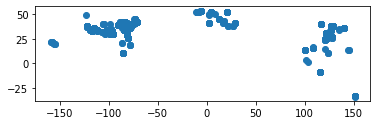

In [27]:
gdf.plot()

### Export

In [28]:
df.to_json("data/processed/checkins.json", orient="records", indent=4)

In [29]:
gdf.to_file("data/processed/geo_checkins.json", driver="GeoJSON")